# Dynamic recurrent neural networks for sequence classification with TensorFlow Eager
----

Hello everyone! In this tutorial, we are going to build a recurrent neural network for sentiment analysis on IMDB movie reviews. I've chosen this dataset as it is small in size and very easy to download by any of you so that there's no bottleneck in data acquisition :).

The main aim of this tutorial is not focused on teaching you how to build a simple RNN, but rather on how to build a RNN that gives you more flexibility in the model development (e.g. use a new RNN cell that is not currently available in Keras, easier access to the unrolled outputs of the RNN, read data in batches from disk). My hope is to be able to give you a glimpse on how you can go on and build your own models, no matter how complicated they might get, in whatever area might be of interest to you.

### Tutorial steps
----
![img](tutorials_graphics/04_flowchart.png)

* *Download the **raw data** and transfer it to **TFRecords** (the default TensorFlow file format).*
* *Prepare a **dataset Iterator** that reads data in batches, from disk, and automatically pads the input data of  variable length to the maximum size within a batch.*
* *Build a **word-level RNN** model with both **LSTM** and **UGRNN cells**.*
* *Compare the performance of both cells on the test dataset.*
* **Save/restore trained model**
* *Test the network on new reviews*
* *Visualize RNN activations*


If you would like to add anything to this tutorial please let me know. Also, I am happy to hear any suggestions you have for improvement.

## Import useful libraries
----

In [2]:
# Import functions to write and parse TFRecords
from data_utils import imdb2tfrecords
from data_utils import parse_imdb_sequence

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import pandas for data processing and pickle for data reading
import pandas as pd
import pickle

# Import library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution(device_policy=tfe.DEVICE_PLACEMENT_SILENT)

## Download data and transfer it to TFRecords
----

**Alternatively, if you clone this repository, you will automatically download the parsed data to TFRecords, so feel free to skip this step.** 

*Large Movie Review Dataset is 'a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets'* (source [here](http://ai.stanford.edu/~amaas/data/sentiment/)). It is comprised of a train dataset with 25000 reviews (12500 positive and 125000 negative) and a test dataset with 25000 reviews as well (12500 positive and 125000 negative).

Here is an example of a positive review:

`
Rented the movie as a joke. My friends and I had so much fun laughing at it that I went and found a used copy and bought it for myself. Now when all my friends are looking for a funny movie I give them Sasquatch Hunters. It needs to be said though there is a rule that was made that made the movie that much better. No talking is allowed while the movie is on unless the words are Sasquatch repeated in a chant. I loved the credit at the end of the movie as well. "Thanks for the Jeep, Tom!" Whoever Tom is I say thank you because without your Jeep the movie may not have been made. In short a great movie if you are looking for something to laugh at. If you want a good movie maybe look for something else but if you don't mind a laugh at the expense of a man in a monkey suit grab yourself a copy.
`

And here is an example of a negative review: 

`
The Good: I liked this movie because it was the first horror movie I've seen in a long time that actually scared me. The acting wasn't too bad, and the "Cupid" killer was believable and disturbing. The Bad: The story line and plot of this movie is incredibly weak. There just wasn't much to it. The ways the killer killed his victims was very horrifying and disgusting. I do not recommend this movie to anyone who can not handle gore. Overall: A good scare, but a bad story.
`

To download this dataset, simply run in the terminal:
> **chmod o+x datasets/get_imdb_dataset.sh**

> **datasets/get_imdb_dataset.sh**

Let's have a look at the distribution of the reviews' lengths (number of words/review):

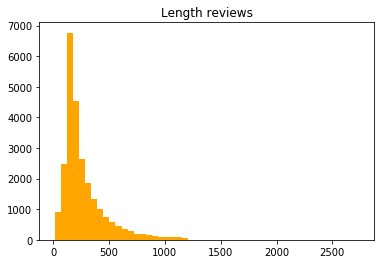

In [4]:
length_reviews = pickle.load(open('datasets/aclImdb/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=50, color='orange');
plt.grid(False);

It seems that the majority of reviews have around 250 words. However, the distribution seems to have a really long tail due to some reviews that are quite long. As we will have to pad the variable length input sequence to the largest sequence in the batch, it will be quite ineficcient to keep these reviews. 

Thus, I have added an argument to the *imdb2tfrecords* function where you can specify the maximum number of words allowed in a review. This will simply take the last *max_words* in a review to make the training more efficient and avoid unrolling the neural network for many many timesteps, which can lead to memory problems. 

After downloading the dataset, simply run the *imdb2tfrecords* function. This function will parse each review into a list of word indices. 

In [5]:
# Function to process the raw data to TFRecords, indexing each word in the review to an integer index.
#imdb2tfrecords(path_data='datasets/aclImdb/', min_word_frequency=5, max_words_review=700)

At the end of this processing, each tfrecord will be composed of:

| TFrecord:        | Description           | 
|:----------------:|:---------------------:| 
| 'token_indexes'  | the sequence of word indexes present in the review|
| 'target'      | 0 for negative sentiment or 1 for positive sentiment |
| 'sequence_length' | the sequence length of the review.|

If you would like to test this RNN network with a new dataset, please have a look at the *imdb2tfrecords* or *parse_imdb_sequence* in the *data_utils.py* script in order to understand how you could parse your new data to TFRecords. I really recommend using this file format as it makes is very easy to work with very large datasets, without being constrained to your RAM capabilities.

## Creating a train and test dataset iterator
----    

In [6]:
train_dataset = tf.data.TFRecordDataset('datasets/aclImdb/train.tfrecords')
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [7]:
test_dataset = tf.data.TFRecordDataset('datasets/aclImdb/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [8]:
# Read the word vocabulary
word2idx = pickle.load(open('datasets/aclImdb/word2idx.pkl', 'rb'))

## RNN model for sequence classification, compatible with Eager API 
----
In the cell below, you can find the class that I have created for the RNN model. The API is very similar with one I created in the previous tutorial, except that now we track the accuracy of the model instead of the loss.

The idea of the network is very simple. We simply take each word in the review, select its corresponding word embedding (initialized randomly in the beginning), and pass it through the RNN cell. We then take the output of the RNN cell at the end of the sequence and pass it through a dense layer (with ReLU activation) to obtain the final predictions. 

Like usually, the network inherits from tf.keras.Model in order to keep track of all variables and save/restore them easily.

![img](tutorials_graphics/rnn_imdb.png)

In [9]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.contrib.layers.xavier_initializer()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else UGRNN cell
        else:
            self.rnn_cell = tf.contrib.rnn.UGRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        dropped_output = tf.layers.dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(dropped_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tfe.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tfe.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tfe.metrics.Accuracy('train_acc')
        eval_acc = tfe.metrics.Accuracy('eval_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for X, y, seq_length in tfe.Iterator(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for X, y, seq_length in tfe.Iterator(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.init_variables()

                # Check accuracy eval dataset
                for X, y, seq_length in tfe.Iterator(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.init_variables()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

## Train model with gradient descent and early stopping
----

### Model training with simple LSTM cells
----

In [10]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0' if tfe.num_gpus()>0 else 'cpu:0'

# Define optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

In [11]:
# Train model
lstm_model.fit(train_dataset, test_dataset, optimizer, num_epochs=500, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

Train accuracy at epoch 1:  0.72308
Eval accuracy at epoch 1:  0.68372
Train accuracy at epoch 2:  0.77708
Eval accuracy at epoch 2:  0.75472
Train accuracy at epoch 3:  0.875
Eval accuracy at epoch 3:  0.82036
Train accuracy at epoch 4:  0.91728
Eval accuracy at epoch 4:  0.8542
Train accuracy at epoch 5:  0.94728
Eval accuracy at epoch 5:  0.87464
Train accuracy at epoch 6:  0.96312
Eval accuracy at epoch 6:  0.88228
Train accuracy at epoch 7:  0.97476
Eval accuracy at epoch 7:  0.88624
Train accuracy at epoch 8:  0.9828
Eval accuracy at epoch 8:  0.88344
Train accuracy at epoch 9:  0.98692
Eval accuracy at epoch 9:  0.87036
Train accuracy at epoch 10:  0.99052
Eval accuracy at epoch 10:  0.86724
Train accuracy at epoch 11:  0.9944
Eval accuracy at epoch 11:  0.87088
Train accuracy at epoch 12:  0.99568
Eval accuracy at epoch 12:  0.86068


In [12]:
# Save model
lstm_model.save_model()

### Model training with UGRNN cells 
---

In [13]:
# Define optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

# Instantiate model. This doesn't initialize the variables yet.
ugrnn_model = RNNModel(vocabulary_size=len(word2idx), rnn_cell='ugrnn', 
                       device=device, checkpoint_directory=checkpoint_directory)

In [14]:
# Train model
ugrnn_model.fit(train_dataset, test_dataset, optimizer, num_epochs=500, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)

Train accuracy at epoch 1:  0.71092
Eval accuracy at epoch 1:  0.67688
Train accuracy at epoch 2:  0.82512
Eval accuracy at epoch 2:  0.7982
Train accuracy at epoch 3:  0.88792
Eval accuracy at epoch 3:  0.84116
Train accuracy at epoch 4:  0.92156
Eval accuracy at epoch 4:  0.85076
Train accuracy at epoch 5:  0.94592
Eval accuracy at epoch 5:  0.86476
Train accuracy at epoch 6:  0.95984
Eval accuracy at epoch 6:  0.87104
Train accuracy at epoch 7:  0.9708
Eval accuracy at epoch 7:  0.87188
Train accuracy at epoch 8:  0.9786
Eval accuracy at epoch 8:  0.8748
Train accuracy at epoch 9:  0.98412
Eval accuracy at epoch 9:  0.86452
Train accuracy at epoch 10:  0.9882
Eval accuracy at epoch 10:  0.86172
Train accuracy at epoch 11:  0.9938
Eval accuracy at epoch 11:  0.86808
Train accuracy at epoch 12:  0.9956
Eval accuracy at epoch 12:  0.8596
Train accuracy at epoch 13:  0.997
Eval accuracy at epoch 13:  0.86368


### Performance comparison
---

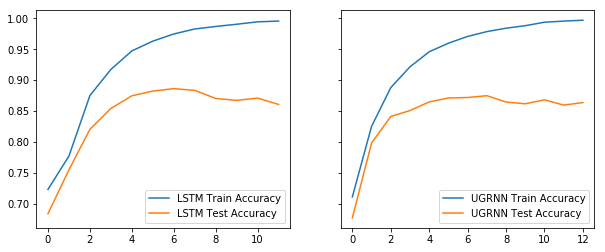

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ax1.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy');
ax1.plot(range(len(lstm_model.history['eval_acc'])), lstm_model.history['eval_acc'], 
         label='LSTM Test Accuracy');
ax2.plot(range(len(ugrnn_model.history['train_acc'])), ugrnn_model.history['train_acc'],
         label='UGRNN Train Accuracy');
ax2.plot(range(len(ugrnn_model.history['eval_acc'])), ugrnn_model.history['eval_acc'],
         label='UGRNN Test Accuracy');
ax1.legend();
ax2.legend();

## Test network on new reviews
---

I think it will be nice to test the network on new reviews that appeared recently on IMDb. I have selected three reviews posted on February 2018 for the movie Bad Apples. Feel free to play with new reviews or invent a new one yourself! The network mananaged to identify the sentiment correctly in all three cases so I am pretty impressed :).

In [16]:
################################################################
# Restore trained model
################################################################
tf.reset_default_graph()
checkpoint_directory = 'models_checkpoints/ImdbRNN/'
device = 'gpu:0' if tfe.num_gpus()>0 else 'cpu:0'
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)
lstm_model.restore_model()

INFO:tensorflow:Restoring parameters from models_checkpoints/ImdbRNN/-0


In [17]:
###############################################################
# Import/download necessary libraries to process new sequences
###############################################################
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

In [18]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [19]:
sent_dict = {0: 'negative', 1: 'positive'}

In [20]:
review_score_10 = "I think Bad Apples is a great time and I recommend! I enjoyed the opening, which gave way for the rest of the movie to occur. The main couple was very likable and I believed all of their interactions. They had great onscreen chemistry and made me laugh quite a few times! Keeping the girls in the masks but seeing them in action was something I loved. It kept a mystery to them throughout. I think the dialogue was great. The kills were fun. And the special surprise gore effect at the end was AWESOME!! I won't spoil that part ;) I also enjoyed how the movie wrapped up. It gave a very urban legends type feel of \"did you ever hear the story...\". Plus is leaves the door open for another film which I wouldn't mind at all. Long story short, I think if you take the film for what it is; a fun little horror flick, then you won't be disappointed! HaPpY eArLy HaLLoWeEn!"

In [21]:
review_score_4 = "A young couple comes to a small town, where the husband get a job working in a hospital. The wife which you instantly hate or dislike works home, at the same time a horrible murders takes place in this small town by two masked killers. Bad Apples is just your tipical B-horror movie with average acting (I give them that. Altough you may get the idea that some of the actors are crazy-convervative Christians), but the script is just bad, and that's what destroys the film."

In [22]:
review_score_1 = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor...the attacks by the \"girls\" are like going back in time, to watching the old rocky films, were blows never touched. the editing is poor with it aswell, example the actress in is the bath when her husband comes home, clearly you see her wearing a flesh coloured bra in the bath. no hints or spoilers, just wait till you find it in a bargain basket of cheap dvds in a couple of weeks"

In [23]:
new_reviews = [review_score_10, review_score_4, review_score_1]
scores = [10, 4, 1]

In [24]:
with tf.device(device):
    for original_review, score in zip(new_reviews, scores):
        indexed_review, seq_length = process_new_review(original_review)
        indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model.predict(indexed_review, seq_length, False)
        pred = tf.argmax(logits, axis=1).numpy()[0]
        print('The sentiment for the review with score %d was found to be %s'
              %(score, sent_dict[pred]))

The sentiment for the review with score 10 was found to be positive
The sentiment for the review with score 4 was found to be negative
The sentiment for the review with score 1 was found to be negative


## Visualizing RNN cell activations
----

The part of this tutorial has been inspired by the work of Karpathy in "Visualizing and understanding recurrent neural networks" ([link here](https://arxiv.org/abs/1506.02078)).

We will use the library seaborn for plotting the heatmap. You can get it by typing in the terminal:
> **pip install seaborn**

In [25]:
# Import libraries for RNN visualization
import seaborn as sns

In [26]:
def VisualizeRNN(model, X):
    ''' Function to return the tanh of the cell state at each timestep.
        
        Args:
            model: trained RNN model.
            X: indexed review of shape (1, sequence_length).
            
        Returns:
            tanh(cell_states): the tanh of the memory cell at each timestep.       
    '''
    
    # Initialize LSTM cell state with zeros
    state = model.rnn_cell.zero_state(1, dtype=tf.float32)
    
    # Get the embedding of each word in the sequence
    embedded_words = model.embeddings(X)

    # Unstack the embeddings
    unstacked_embeddings = tf.unstack(embedded_words, axis=1)

    # Iterate through each timestep and append its cell state
    cell_states = []
    for input_step in unstacked_embeddings:
        _, state = model.rnn_cell(input_step, state)
        cell_states.append(state[0])
        
    # Stack cell_states to (batch_size, time_steps, cell_size)
    cell_states = tf.stack(cell_states, axis=1)
    return tf.tanh(cell_states)

In [27]:
# Feel free to modify here the input! 
dummy_review = "When you first start watching this movie, you can tell its going to be a painful ride. the audio is poor..."

In [28]:
# Processing new review
indexed_review, seq_length = process_new_review(dummy_review)
indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))

In [29]:
# Get the cell states
cell_states = VisualizeRNN(lstm_model, indexed_review)

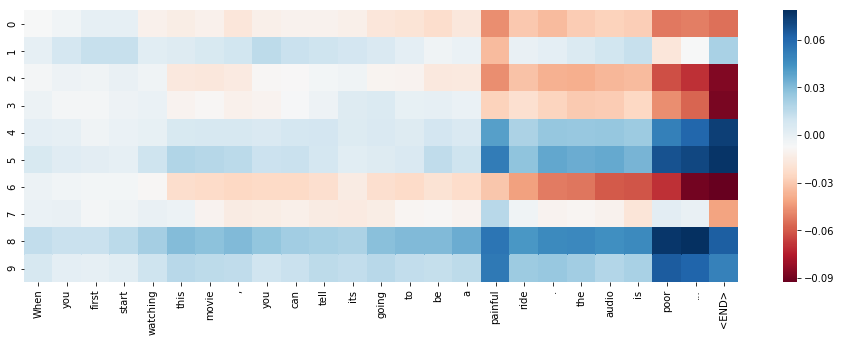

In [30]:
# Plot activations of the first 10 units in the cell (the cell has 64 units in total)
plt.figure(figsize = (16,5))
sns.heatmap(cell_states.numpy()[0,:,:10].T, 
            xticklabels=word_tokenize(dummy_review)+['<END>'],
            cmap='RdBu');